In [ ]:
!pip install tensorflow
!pip install seaborn rdkit pubchempy shap



In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from tensorflow import keras
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.utils import to_categorical
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder

from rdkit.Chem.rdchem import Mol
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error
import pubchempy as pcp
from pubchempy import get_compounds

In [2]:
dataset = pd.read_csv('Dataset.csv')
dataset = dataset[['Micro Pollutant','Initial Concentration of MP (mg/L)', 'Compound MW (g/mol)', 'Compound Charge', 'Log D (pH=6.5-7)','pKa','Initial FS pH', 'Type of MB', 'Draw Solution','DS MW (g mol-1)', 'DS Concentration (M)', 'Operating Time (h)', 'Cross Flow Velocity (cm/s)','Water Flux, Jw (LMH)','Reverse Salt Flux, Js (gMH)','Temperature (⁰C)', 'Removal Rate (%)']]
dataset = dataset[(dataset['Type of MB'] == 'HTI CTA FO') | (dataset['Type of MB'] == 'HTI PA FO') | (dataset['Type of MB'] == 'Aquaporin FO')]


In [ ]:
Micro_Pollutant=dataset['Micro Pollutant']
DS=dataset['Draw Solution']

import time

# Function to retrieve SMILES given a compound name with retries
def get_smiles_with_retries(compound_name, max_retries=3, retry_delay=5):
    retries = 0
    while retries < max_retries:
        try:
            compounds = get_compounds(compound_name, 'name')
            return compounds[0].canonical_smiles if compounds else None
        except Exception as e:
            print(f"Error retrieving SMILES for {compound_name}: {e}")
            retries += 1
            time.sleep(retry_delay)
    return None

# Add SMILES column to the dataset with retries
dataset['SMILES_MP'] = Micro_Pollutant.apply(lambda x: get_smiles_with_retries(x))
dataset['SMILES_DS'] = DS.apply(lambda x: get_smiles_with_retries(x))

In [ ]:
# Generating Molecular Fingerprints of MP and DS

# Convert the 'SMILES_DS' column to RDKit Mol objects
dataset['Molecule_DS'] = dataset['SMILES_DS'].apply(Chem.MolFromSmiles)

# Generate molecular fingerprints for DS
dataset['Fingerprint_DS'] = dataset['Molecule_DS'].apply(lambda x: AllChem.RDKFingerprint(x))

# Convert DS fingerprints to a binary representation
dataset['Fingerprint_Bits_DS'] = dataset['Fingerprint_DS'].apply(lambda x: x.ToBitString())

# Convert the 'SMILES_MP' column to RDKit Mol objects
dataset['Molecule_MP'] = dataset['SMILES_MP'].apply(Chem.MolFromSmiles)

# Generate molecular fingerprints for MP
dataset['Fingerprint_MP'] = dataset['Molecule_MP'].apply(lambda x: AllChem.RDKFingerprint(x))

# Convert MP fingerprints to a binary representation
dataset['Fingerprint_Bits_MP'] = dataset['Fingerprint_MP'].apply(lambda x: x.ToBitString())

# Split both DS and MP fingerprint bits and create separate columns for each bit
for i in range(len(dataset['Fingerprint_Bits_DS'][0])):
    dataset[f'DS_Bit_{i}'] = dataset['Fingerprint_Bits_DS'].apply(lambda x: int(x[i]))

for i in range(len(dataset['Fingerprint_Bits_MP'][0])):
    dataset[f'MP_Bit_{i}'] = dataset['Fingerprint_Bits_MP'].apply(lambda x: int(x[i]))

# Calculate variance for each DS bit column
ds_bit_columns = [f'DS_Bit_{i}' for i in range(len(dataset['Fingerprint_Bits_DS'][0]))]
ds_bit_variances = dataset[ds_bit_columns].var()

# Calculate variance for each MP bit column
mp_bit_columns = [f'MP_Bit_{i}' for i in range(len(dataset['Fingerprint_Bits_MP'][0]))]
mp_bit_variances = dataset[mp_bit_columns].var()

# Set a threshold for low variance (you can adjust this threshold)
low_variance_threshold = 0.1

# Identify DS columns with low variance
low_variance_columns_ds = ds_bit_variances[ds_bit_variances < low_variance_threshold].index

# Identify MP columns with low variance
low_variance_columns_mp = mp_bit_variances[mp_bit_variances < low_variance_threshold].index

# Drop columns with low variance for DS and MP
dataset.drop(low_variance_columns_ds, axis=1, inplace=True)
dataset.drop(low_variance_columns_mp, axis=1, inplace=True)
dataset.drop(columns=['Micro Pollutant','Draw Solution' ,'SMILES_MP','SMILES_DS', 'Molecule_MP','Molecule_DS','Fingerprint_Bits_MP','Fingerprint_Bits_DS','Fingerprint_MP','Fingerprint_DS'], inplace=True)

dataset = pd.get_dummies(dataset, columns=['Type of MB'], prefix='MB', drop_first=True)
X = dataset.drop(columns=['Removal Rate (%)'])  # Features (all columns except the target)
y = dataset['Removal Rate (%)']

# Retrieve the feature names before scaling
feature_names = X.columns

dataset

In [ ]:
dataset.dropna(subset=['Water Flux, Jw (LMH)'], inplace=True)
dataset.dropna(subset=['Removal Rate (%)'], inplace=True)


In [ ]:
#dataset.to_csv('output.csv', index=False)


In [36]:
dataset = pd.read_csv('output.csv')


In [37]:
from sklearn.impute import KNNImputer
# Create a KNNImputer
imputer = KNNImputer(n_neighbors=50)  # You can adjust the number of neighbors
columns_to_impute = [
    'Initial Concentration of MP (mg/L)',
    'Compound MW (g/mol)',
    'Compound Charge',
    'Log D (pH=6.5-7)',
    'pKa',
    'DS MW (g mol-1)',
    'DS Concentration (M)',
    'Water Flux, Jw (LMH)',
    'Removal Rate (%)',
    'Reverse Salt Flux, Js (gMH)',
    'Initial FS pH',
    'Operating Time (h)',
    'Cross Flow Velocity (cm/s)',
    'Temperature (⁰C)']

for column in columns_to_impute:
    column_data = dataset[[column]]  # Extract the current column as a DataFrame
    imputed_column = imputer.fit_transform(column_data)
    imputed_column = imputed_column
    dataset.loc[:,column] = imputed_column  # Update the original column with imputed values

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [38]:
#drop_code=df_no_outliers.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]].dropna()
inputsWF = dataset.drop(columns=['Water Flux, Jw (LMH)']) # Features (all columns except the target)
outputsWF = dataset['Water Flux, Jw (LMH)']


In [39]:
#drop_code=df_no_outliers.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]].dropna()
inputsRR = dataset.drop(columns=['Removal Rate (%)'])
outputsRR = dataset['Removal Rate (%)']


In [40]:
inputsRR = inputsRR.to_numpy()
outputsRR = outputsRR.to_numpy()
inputsWF = inputsWF.to_numpy()
outputsWF = outputsWF.to_numpy()

In [41]:
#Scale the numerical features
scaler = StandardScaler()
X_scaledRR = scaler.fit_transform(inputsRR) #Scaling generally refers to transforming the features so that they have a specific range or distribution.

#validation dataset
#vX_scaledRR = scaler.fit_transform(vinputsRR) #Scaling generally refers to transforming the features so that they have a specific range or distribution.

In [42]:
#Scale the numerical features
scaler = StandardScaler()
X_scaledWF = scaler.fit_transform(inputsWF) #Scaling generally refers to transforming the features so that they have a specific range or distribution.

#validation dataset
#vX_scaledWF = scaler.fit_transform(vinputsWF) #Scaling generally refers to transforming the features so that they have a specific range or distribution.

In [43]:
# Set random seeds for reproducibility
import random
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
#In summary, by setting the same random seed value across different libraries,
#you ensure that any random operations performed in your code will produce the same results each time you run the code.
#This is particularly useful for debugging, sharing results, and ensuring the stability of your machine learning models.

In [ ]:
#num_folds = 10 #dataset is divided into n_splits equally sized parts or folds.
#kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed_value)
#setting shuffle to True is recommended to avoid any potential bias due to the original order of your data.
# with random_state, you ensure that the shuffling is consistent across different runs of your code, making your results reproducible.#

In [ ]:
!pip install pydot

In [44]:
#ANN model creation Building a multi-layer neaural network model
# sequential model

tf.keras.backend.clear_session()

ann_modelWF = tf.keras.models.Sequential()
ann_modelRR = tf.keras.models.Sequential()


ann_modelWF = Sequential()
ann_modelWF.add(Dense(units=10, activation='relu', input_shape=inputsWF[1].shape))
#ann_modelWF.add(Dense(units=50, activation='relu'))
#ann_modelWF.add(Dense(units=50, activation='relu'))
#ann_modelWF.add(Dense(units=50, activation='relu'))
#ann_modelWF.add(Dense(units=50, activation='relu'))
#ann_modelWF.add(Dense(units=50, activation='relu'))
#ann_modelWF.add(Dense(units=60, activation='relu'))
#ann_modelWF.add(Dense(units=60, activation='relu'))

ann_modelWF.add(Dense(units=1, activation='linear'))

tf.keras.backend.clear_session()

# Removal Rate model
ann_modelRR = Sequential()
ann_modelRR.add(Dense(units=10, activation='relu', input_shape=inputsRR[1].shape))
#ann_modelRR.add(Dense(units=40, activation='relu'))
#ann_modelRR.add(Dense(units=40, activation='relu'))
#ann_modelRR.add(Dense(units=40, activation='relu'))
#ann_modelRR.add(Dense(units=40, activation='relu'))
#ann_modelRR.add(Dense(units=60, activation='relu'))
#ann_modelRR.add(Dense(units=40, activation='relu'))
#ann_modelRR.add(Dense(units=40, activation='relu'))

ann_modelRR.add(Dense(units=1, activation='linear'))


######
ann_modelWF.summary()
from keras.utils import plot_model
plot_model(ann_modelWF, show_shapes=True)

ann_modelRR.summary()
plot_model(ann_modelRR, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                14380     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 14391 (56.21 KB)
Trainable params: 14391 (56.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                14380     
                                               

In [ ]:
tf.keras.backend.clear_session()


In [45]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
import numpy as np

# Define the number of folds
num_folds = 9
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists for loss and metrics storing for all 9 folds
all_train_loss = []
all_valid_loss = []
all_train_water_flux_mae = []
all_valid_water_flux_mae = []
all_train_removal_rate_mae = []
all_valid_removal_rate_mae = []

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Define your model outside of the loop if it doesn't change across folds
ann_modelRR.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training loop with 9-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaledRR)):
    print(f"Training on fold {fold+1}/{num_folds}")

    X_trainRR, X_valRR =  X_scaledRR[train_idx],  X_scaledRR[val_idx]
    outputsRR_train, outputsRR_val = outputsRR[train_idx], outputsRR[val_idx]

    # Train the model with early stopping
    historyRR =  ann_modelRR.fit(X_trainRR, outputsRR_train,
                                validation_data=(X_valRR, outputsRR_val),
                                epochs=100, batch_size=32, verbose=1,
                                callbacks=[early_stopping])

    # Collect loss and metrics for this fold
    all_train_removal_rate_mae.append(historyRR.history['mae'])
    all_valid_removal_rate_mae.append(historyRR.history['val_mae'])

# Calculate and print the mean metrics across all folds
mean_train_mae = np.mean(all_train_removal_rate_mae, axis=0)
mean_valid_mae = np.mean(all_valid_removal_rate_mae, axis=0)

print("Mean Training MAE:", mean_train_mae)
print("Mean Validation MAE:", mean_valid_mae)


Training on fold 1/9
Epoch 1/100
10/10 [==============================] - 1s 21ms/step - loss: 7138.8579 - mae: 81.8935 - val_loss: 6835.2915 - val_mae: 80.9716
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 6634.4507 - mae: 78.8113 - val_loss: 6284.0596 - val_mae: 77.5035
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 6131.1338 - mae: 75.5452 - val_loss: 5699.9873 - val_mae: 73.5692
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 5622.0947 - mae: 72.0483 - val_loss: 5107.2236 - val_mae: 69.2754
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 5104.0645 - mae: 68.2739 - val_loss: 4526.9844 - val_mae: 64.7441
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 4590.2036 - mae: 64.3629 - val_loss: 3990.9226 - val_mae: 60.2950
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 4083.5322 - mae: 60.1763 - val_loss: 3486.8833 - val_mae: 55.8664
Epoch

Training on fold 4/9
Epoch 1/100
10/10 [==============================] - 0s 10ms/step - loss: 126.6343 - mae: 6.9377 - val_loss: 133.9989 - val_mae: 6.7741
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 123.6289 - mae: 6.8735 - val_loss: 139.6041 - val_mae: 6.8817
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 121.1659 - mae: 6.8413 - val_loss: 142.1186 - val_mae: 6.9622
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 120.5069 - mae: 6.8255 - val_loss: 147.9490 - val_mae: 7.0710
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 118.1069 - mae: 6.7286 - val_loss: 149.9700 - val_mae: 7.0823
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 116.9050 - mae: 6.7067 - val_loss: 152.1579 - val_mae: 7.0866
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 115.8321 - mae: 6.6858 - val_loss: 156.6510 - val_mae: 7.2658
Epoch 8/100
10/10 [==============

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [46]:
#using valuation dataset created from the folds.
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model on test data
y_predRR = ann_modelRR.predict(X_valRR)

    # Save predictions to CSV
predictions_RR = pd.DataFrame({'Actual': outputsRR_val.flatten(), 'Predicted': y_predRR.flatten()})
predictions_RR.to_csv(f'predictionscombinedRR_fold{fold+1}.csv', index=False)

    # Calculation of R2, RMSE, and Adjusted R2 for Removal Rate
r2_removal_rate = r2_score(outputsRR_val, y_predRR)
print(f"Fold {fold+1} - R-squared for Removal Rate: {r2_removal_rate:.4f}")
rmse_removal_rate = np.sqrt(mean_squared_error(outputsRR_val, y_predRR))
print(f"Fold {fold+1} - RMSE for Removal Rate: {rmse_removal_rate:.4f}")
rmspeRR = np.sqrt(np.mean(np.square(((outputsRR_val - y_predRR) / outputsRR_val))))
print(f"Fold {fold+1} - Percentage RMSE for Removal Rate: {rmspeRR:.4f}%")
n = len(outputsRR_val)
p = X_valRR.shape[1]
adj_r2_removal_rate = 1 - (1 - r2_removal_rate) * (n - 1) / (n - p - 1)
print(f"Fold {fold+1} - Adjusted R-squared for Removal Rate: {adj_r2_removal_rate:.4f}")

2/2 [==============================] - 0s 5ms/step
Fold 9 - R-squared for Removal Rate: 0.6689
Fold 9 - RMSE for Removal Rate: 11.1911
Fold 9 - Percentage RMSE for Removal Rate: 0.7048%
Fold 9 - Adjusted R-squared for Removal Rate: 1.0090


In [47]:
# Training loop with k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaledWF)):
    print(f"Training on fold {fold+1}/{num_folds}")

    X_trainWF, X_valWF = X_scaledWF[train_idx], X_scaledWF[val_idx]
    outputsWF_train, outputsWF_val = outputsWF[train_idx], outputsWF[val_idx]

    # Compile the models
    ann_modelWF.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

    # Train the models with early stopping
    historyWF = ann_modelWF.fit(X_trainWF, outputsWF_train,
                                validation_data=(X_valWF, outputsWF_val),
                                epochs=100, batch_size=32, verbose=1,
                                callbacks=[early_stopping])

    # Collect loss and metrics for this fold
    all_train_loss.append(historyWF.history['loss'])
    all_valid_loss.append(historyWF.history['val_loss'])
    all_train_water_flux_mae.append(historyWF.history['mae'])
    all_valid_water_flux_mae.append(historyWF.history['val_mae'])

Training on fold 1/9
Epoch 1/100
10/10 [==============================] - 1s 18ms/step - loss: 99.9395 - mae: 9.1580 - val_loss: 80.1503 - val_mae: 7.8941
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 59.4222 - mae: 6.5229 - val_loss: 54.8202 - val_mae: 5.9600
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 37.0378 - mae: 4.8790 - val_loss: 41.6245 - val_mae: 5.0620
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 24.4661 - mae: 3.7907 - val_loss: 34.4609 - val_mae: 4.5324
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 18.7971 - mae: 3.1957 - val_loss: 31.6185 - val_mae: 4.3491
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 15.8225 - mae: 2.9460 - val_loss: 30.8196 - val_mae: 4.3933
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 14.4357 - mae: 2.8137 - val_loss: 30.2284 - val_mae: 4.3767
Epoch 8/100
10/10 [============================

In [32]:
# Save model weights and architecture
#ann_modelRR.save('C:\Users\mehry\OneDrive - University of Bath\Bath\EDU\MSc_Thesis\ANN\ann_model_RR_2_100.h5')
ann_modelWF.save('C:\\Users\\mj943\\OneDrive - University of Bath\\Bath\\EDU\\MSc_Thesis\\ANN\\ann_model_WF_2_10.h5')
ann_modelRR.save('C:\\Users\\mj943\\OneDrive - University of Bath\\Bath\\EDU\\MSc_Thesis\\ANN\\ann_model_RR_2_10.h5')


# Save training history
history_df = pd.DataFrame(historyRR.history)
history_df.to_csv('C:\\Users\\mj943\\OneDrive - University of Bath\\Bath\\EDU\\MSc_Thesis\\ANN\\training_history_RR_2_100.csv', index=False)
history_df = pd.DataFrame(historyWF.history)
history_df.to_csv('C:\\Users\\mj943\\OneDrive - University of Bath\\Bath\\EDU\\MSc_Thesis\\ANN\\training_history_WF_2_10.csv', index=False)

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [48]:
#using valuation dataset created from the folds.
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model on test data
y_predWF = ann_modelWF.predict(X_valWF)

    # Save predictions to CSV
predictions_WF = pd.DataFrame({'Actual': outputsWF_val.flatten(), 'Predicted': y_predWF.flatten()})
predictions_WF.to_csv(f'predictionscombinedWF_fold{fold+1}.csv', index=False)

# Calculation of R2, RMSE, and Adjusted R2 for Water Flux
r2_water_flux = r2_score(outputsWF_val, y_predWF)
print(f"Fold {fold+1} - R-squared for Water Flux: {r2_water_flux:.4f}")
rmse_water_flux = np.sqrt(mean_squared_error(outputsWF_val, y_predWF))
print(f"Fold {fold+1} - RMSE for Water Flux: {rmse_water_flux:.4f}")
rmspeWF = np.sqrt(np.mean(np.square(((outputsWF_val - y_predWF) / outputsWF_val))))
print(f"Fold {fold+1} - Percentage RMSE for Water Flux: {rmspeWF:.4f}%")
n = len(outputsWF_val)
p = X_valRR.shape[1]  # Number of input features
adj_r2_water_flux = 1 - (1 - r2_water_flux) * (n - 1) / (n - p - 1)
print(f"Fold {fold+1} - Adjusted R-squared for Water Flux: {adj_r2_water_flux:.4f}")


2/2 [==============================] - 0s 4ms/step
Fold 9 - R-squared for Water Flux: 0.4953
Fold 9 - RMSE for Water Flux: 2.7012
Fold 9 - Percentage RMSE for Water Flux: 0.5525%
Fold 9 - Adjusted R-squared for Water Flux: 1.0137


Evaluation Table WATER FLUX:
    Test Data  Predicted Data
0       17.10       11.247633
1       17.10       12.040197
2       11.01        8.502250
3       11.01        9.103147
4       11.01        7.914619
5       11.01        7.949294
6       11.01        7.488245
7        5.36       12.207742
8        5.36        8.793512
9        5.36        6.512976
10       5.36        9.659809
11      11.64       11.621614
12      17.12       12.095994
13       8.10        8.210345
14       8.10        9.342987
15       6.00        5.705771
16       6.00        5.144718
17      12.00       11.051824
18      12.00       10.697884
19      12.00       10.536904
20      12.00        9.693949
21      12.00        9.975949
22      10.00       10.248147
23      15.00       13.149570
24      15.00       12.796857
25      14.13       11.387453
26       7.75       13.229782
27      10.63       10.402526
28       7.48        8.980579
29       7.32        9.884773
30      15.54       15.516450
31      15.

Text(0.5, 1.0, 'Correlation between Predicted and Test Data for Water Flux')

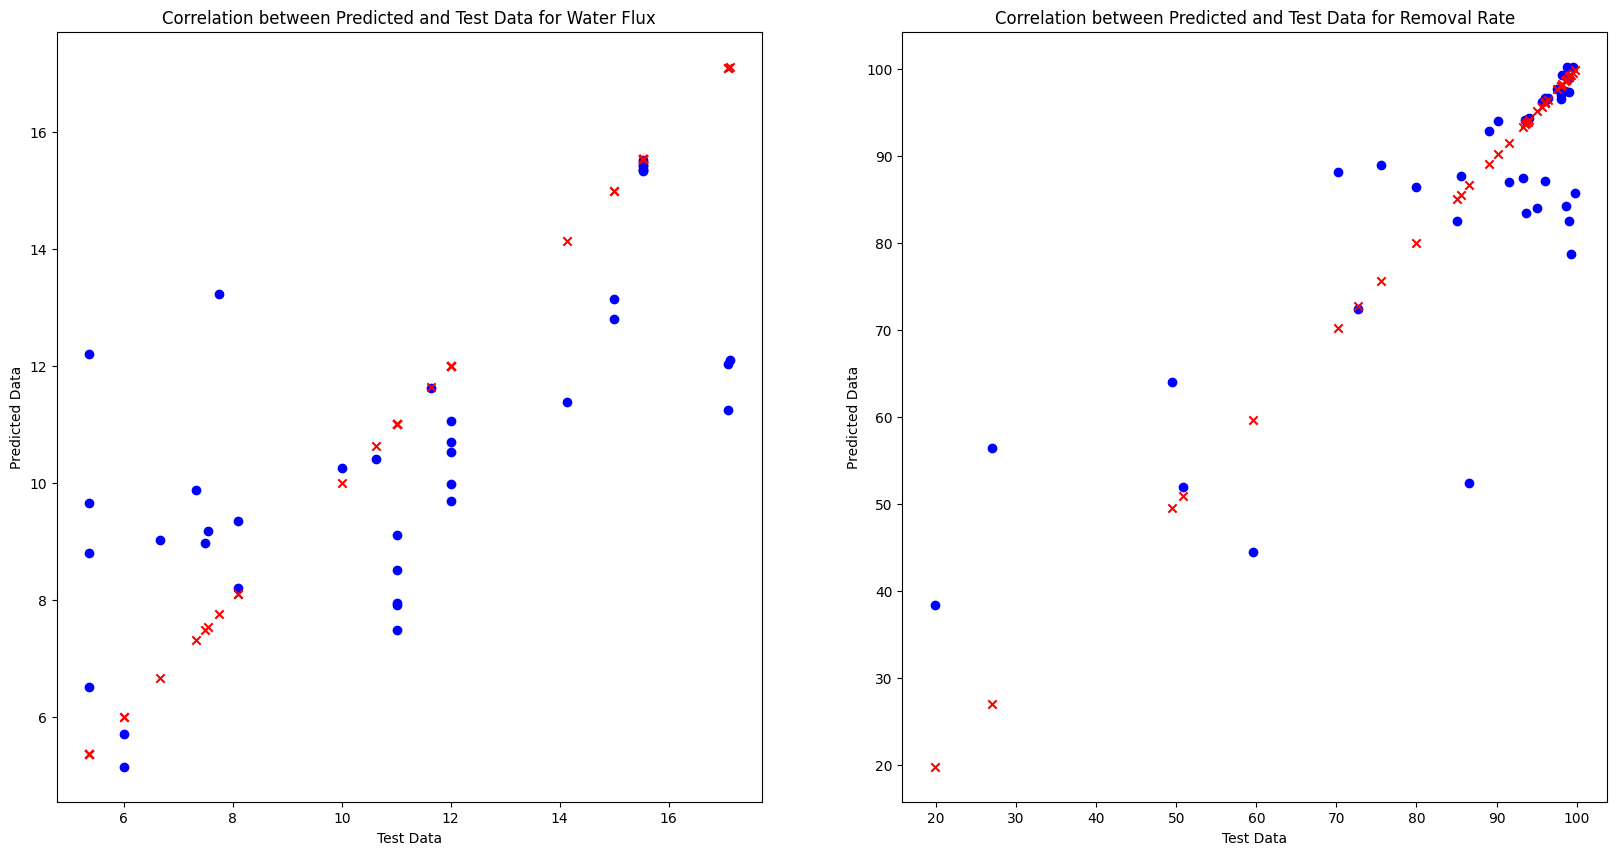

In [49]:
#Create a DataFrame with predicted and test data
evaluation_WF = pd.DataFrame({'Test Data': outputsWF_val.flatten(), 'Predicted Data': y_predWF.flatten()})
evaluation_RR = pd.DataFrame({'Test Data': outputsRR_val.flatten(), 'Predicted Data': y_predRR.flatten()})

# Print the evaluation table
print("Evaluation Table WATER FLUX:")
print(evaluation_WF)
print("Evaluation Table REMOVAL RATE:")
print(evaluation_RR)

fig = pyplot.figure(figsize=(20,10))

# Plot the correlation between predicted and test data
fig.add_subplot(1,2,2)
pyplot.scatter(outputsRR_val, y_predRR, color='blue', label='Predicted', marker='o')
pyplot.scatter(outputsRR_val, outputsRR_val, color='red', label='Actual', marker='x')
pyplot.xlabel('Test Data')
pyplot.ylabel('Predicted Data')
pyplot.title('Correlation between Predicted and Test Data for Removal Rate')


# Plot the correlation between predicted and test data
fig.add_subplot(1,2,1)
pyplot.scatter(outputsWF_val, y_predWF, color='blue', label='Predicted', marker='o')
pyplot.scatter(outputsWF_val, outputsWF_val, color='red', label='Actual', marker='x')
pyplot.xlabel('Test Data')
pyplot.ylabel('Predicted Data')
pyplot.title('Correlation between Predicted and Test Data for Water Flux')

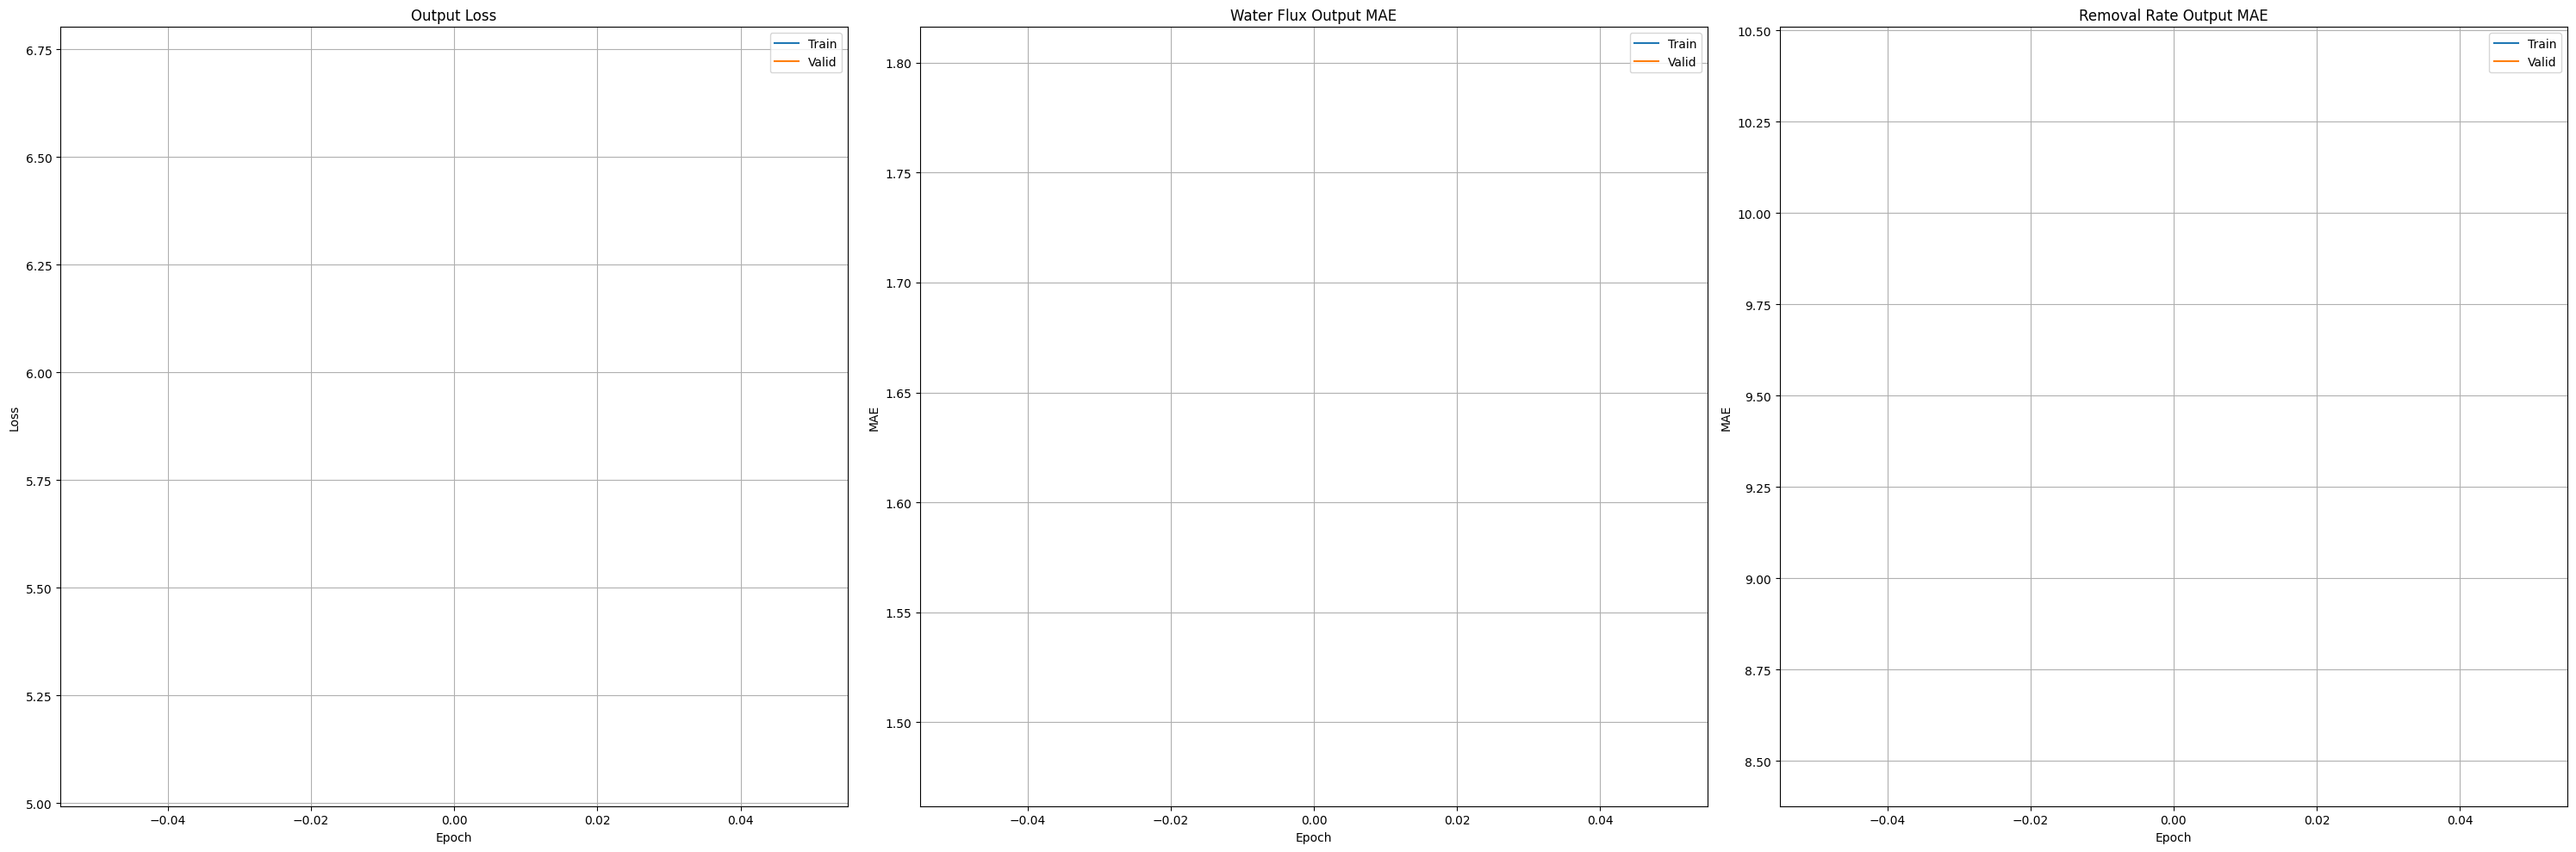

In [18]:
# Average the losses and metrics over all folds
# Flatten the list of arrays into single arrays for all variables
flattened_train_loss = np.concatenate(all_train_loss, axis=0)
flattened_valid_loss = np.concatenate(all_valid_loss, axis=0)
flattened_train_water_flux_mae = np.concatenate(all_train_water_flux_mae, axis=0)
flattened_valid_water_flux_mae = np.concatenate(all_valid_water_flux_mae, axis=0)
flattened_train_removal_rate_mae = np.concatenate(all_train_removal_rate_mae, axis=0)
flattened_valid_removal_rate_mae = np.concatenate(all_valid_removal_rate_mae, axis=0)

# Calculate the mean for all variables
avg_train_loss = np.mean(flattened_train_loss, axis=0)
avg_valid_loss = np.mean(flattened_valid_loss, axis=0)
avg_train_water_flux_mae = np.mean(flattened_train_water_flux_mae, axis=0)
avg_valid_water_flux_mae = np.mean(flattened_valid_water_flux_mae, axis=0)
avg_train_removal_rate_mae = np.mean(flattened_train_removal_rate_mae, axis=0)
avg_valid_removal_rate_mae = np.mean(flattened_valid_removal_rate_mae, axis=0)

# Plot the averaged results
fig, axes = pyplot.subplots(1, 3, figsize=(30, 10))
# Plot Loss
axes[0].plot(avg_train_loss, label='Train')
axes[0].plot(avg_valid_loss, label='Valid')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Output Loss')

# Plot Water Flux MAE
axes[1].plot(avg_train_water_flux_mae, label='Train')
axes[1].plot(avg_valid_water_flux_mae, label='Valid')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Water Flux Output MAE')

# Plot Removal Rate MAE
axes[2].plot(avg_train_removal_rate_mae, label='Train')
axes[2].plot(avg_valid_removal_rate_mae, label='Valid')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('MAE')
axes[2].set_title('Removal Rate Output MAE')

pyplot.tight_layout()
pyplot.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


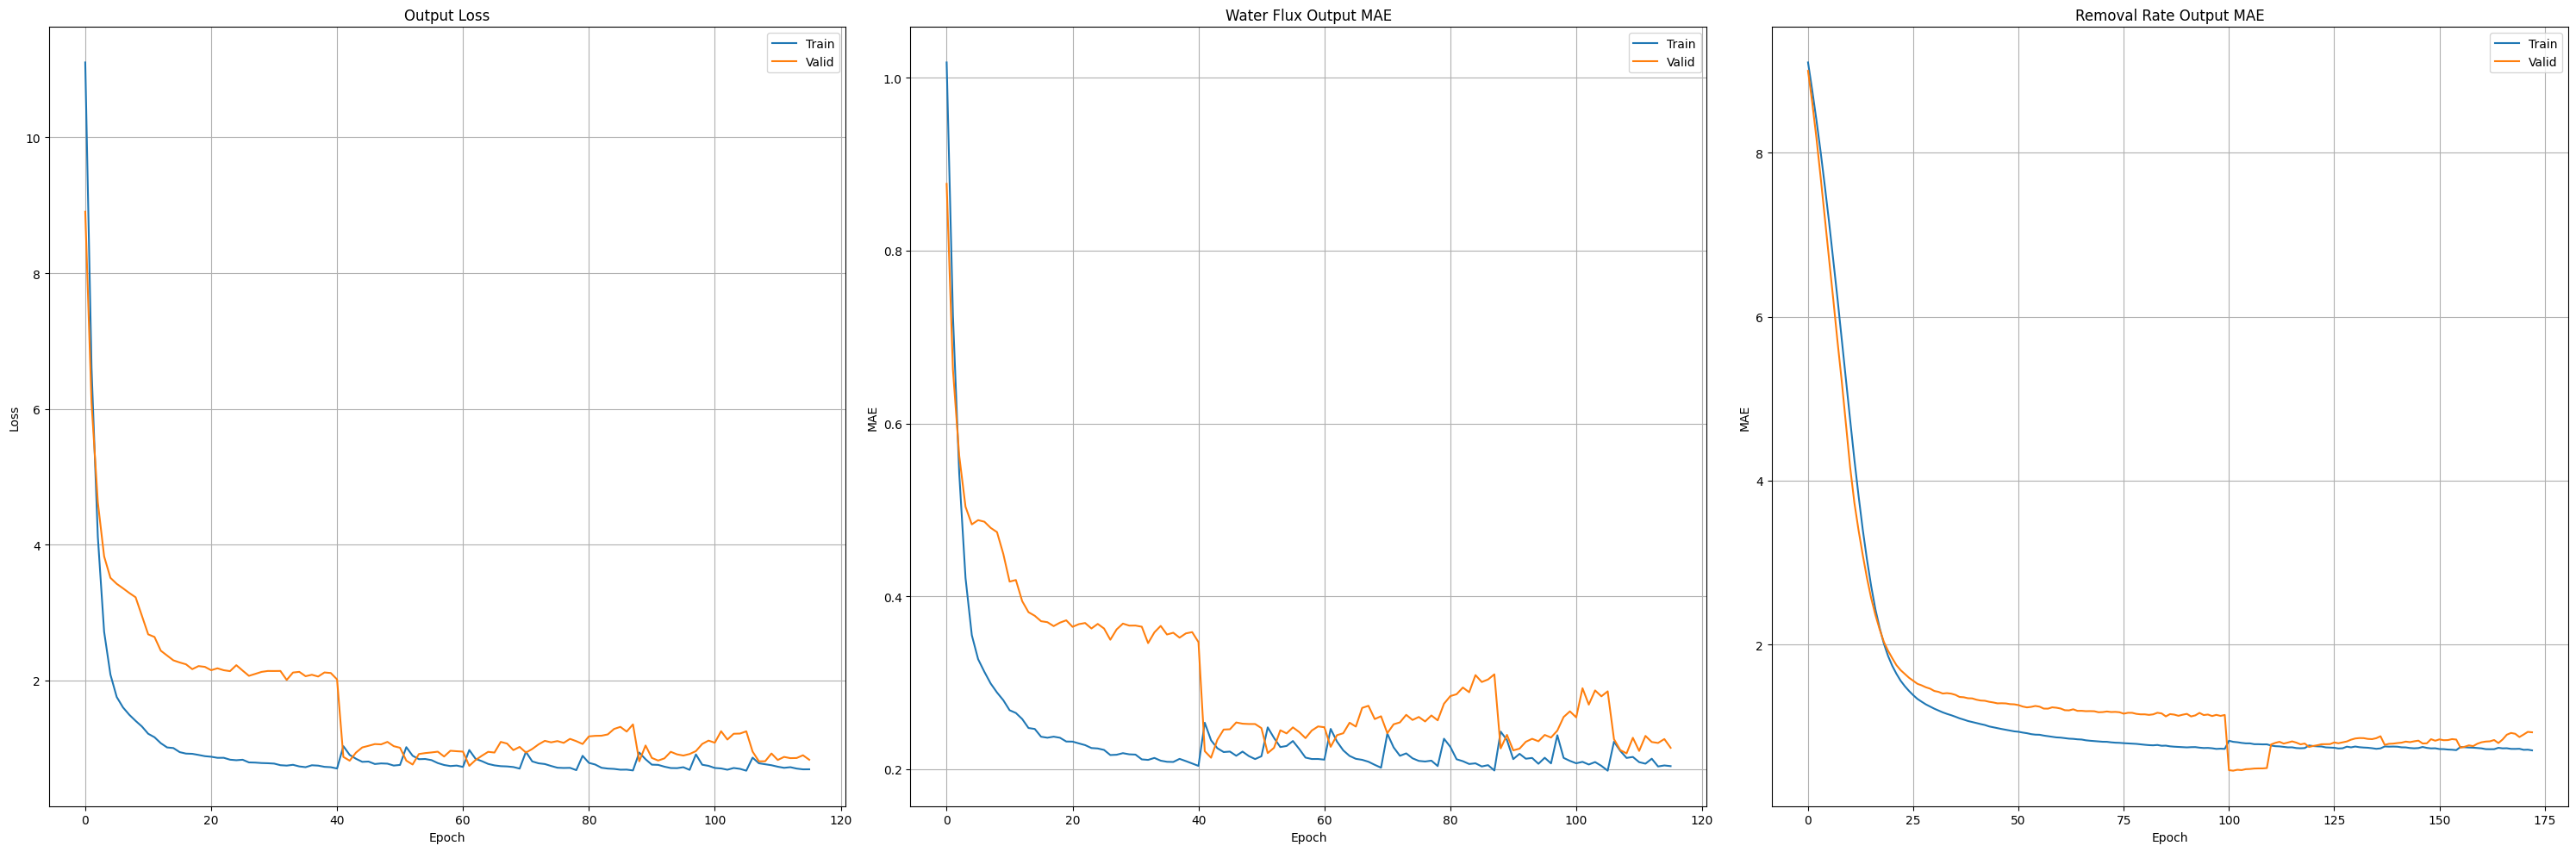

In [50]:
# Average the losses and metrics over all folds
avg_train_loss = np.mean(all_train_loss, axis=0)
avg_valid_loss = np.mean(all_valid_loss, axis=0)
avg_train_water_flux_mae = np.mean(all_train_water_flux_mae, axis=0)
avg_valid_water_flux_mae = np.mean(all_valid_water_flux_mae, axis=0)
avg_train_removal_rate_mae = np.mean(all_train_removal_rate_mae, axis=0)
avg_valid_removal_rate_mae = np.mean(all_valid_removal_rate_mae, axis=0)

# Plot the averaged results
fig, axes = pyplot.subplots(1, 3, figsize=(30, 10))

# Plot Loss
axes[0].plot(avg_train_loss, label='Train')
axes[0].plot(avg_valid_loss, label='Valid')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Output Loss')

# Plot Water Flux MAE
axes[1].plot(avg_train_water_flux_mae, label='Train')
axes[1].plot(avg_valid_water_flux_mae, label='Valid')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Water Flux Output MAE')

# Plot Removal Rate MAE
axes[2].plot(avg_train_removal_rate_mae, label='Train')
axes[2].plot(avg_valid_removal_rate_mae, label='Valid')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('MAE')
axes[2].set_title('Removal Rate Output MAE')

pyplot.tight_layout()
pyplot.show()

In [52]:
all_train_loss

[[99.93950653076172,
  59.42219161987305,
  37.03779983520508,
  24.466096878051758,
  18.797107696533203,
  15.822450637817383,
  14.43565845489502,
  13.462182998657227,
  12.656888008117676,
  11.915288925170898,
  10.949247360229492,
  10.486486434936523,
  9.697596549987793,
  9.136665344238281,
  9.052864074707031,
  8.513605117797852,
  8.319774627685547,
  8.288788795471191,
  8.139655113220215,
  7.97770881652832,
  7.899892330169678,
  7.759273529052734,
  7.7618794441223145,
  7.511056900024414,
  7.440799236297607,
  7.5034003257751465,
  7.150642395019531,
  7.1265549659729,
  7.066246509552002,
  7.041143417358398,
  6.993264198303223,
  6.7807159423828125,
  6.727040767669678,
  6.831201553344727,
  6.618422031402588,
  6.518743515014648,
  6.771734714508057,
  6.724032402038574,
  6.565244674682617,
  6.516079425811768,
  6.3403449058532715],
 [9.305680274963379,
  8.145827293395996,
  7.63356351852417,
  7.226746082305908,
  7.260896682739258,
  6.938295364379883,
  7.

In [51]:
import shap
# Fits the explainer
explainer = shap.Explainer(ann_modelRR.predict, X_valRR)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_valRR)
# Evaluate SHAP values
shap_values = explainer.shap_values(X_scaledRR)

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 2875!

In [24]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for your model
explainer = shap.Explainer(ann_modelRR.predict)

# Calculate SHAP values for your test data
shap_values = explainer.shap_values(X_test_scaled)

# Plot feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title("Feature Importance")
#plt.show()

# Plot SHAP values for a specific instance (adjust 'instance_index' as needed)
instance_index = 0  # Change this to the index of the instance you want to visualize
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(explainer.expected_value[0], shap_values[0][instance_index], X_test_scaled.iloc[instance_index], feature_names=X.columns)
plt.title("SHAP Values for Instance")
plt.show()



ValueError: masker cannot be None.

In [22]:
#!pip install --upgrade numba shap

#!pip install shap
import shap
# Fits the explainer
#explainer = shap.Explainer(ann_modelRR.predict, X_valRR)
# Calculates the SHAP values - It takes some time
#shap_values = explainer(X_valRR)
explainer = shap.Explainer(ann_modelRR.predict, X_valRR)
shap_values = explainer(X_valRR, max_evals=3000)  # Adjust the value based on your needs
# Evaluate SHAP values
shap_values = explainer.shap_values(X_scaledRR)




ValueError: max_evals=1000 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 2875!

In [ ]:
feature_names = ['Fingerprint_MP', 'Initial Concentration of MP (mg/L)', 'MP Category', 'Compound MW (g/mol)', 'Compound Charge', 'Log Kow', 'pKa', 'Initial FS pH', 'Type of MB', 'MB Contact Angle (°)', 'MB Zeta Potential (mV)', 'Fingerprint_DS', 'DS Molecular weight (g mol-1)', 'DS Concentration (M)', 'Operating Time (h)', 'Cross flow velocity (cm/s)', 'Temperature (⁰C)']
num_features = X_scaledRR.shape[1]  # Number of features

# Assuming shap_values is a 2D array of shape (num_samples, num_features)
shap.summary_plot(shap_values, X_scaledRR, feature_names=feature_names,
                  plot_type='violin', color=pyplot.cm.viridis)

pyplot.show()

In [ ]:
# Fits the explainer
explainer = shap.Explainer(ann_modelWF.predict, X_valWF)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_valWF)
# Evaluate SHAP values
shap_values = explainer.shap_values(X_scaledWF)

In [ ]:
feature_names = ['Fingerprint_MP', 'Initial Concentration of MP (mg/L)', 'MP Category', 'Compound MW (g/mol)', 'Compound Charge', 'Log Kow', 'pKa', 'Initial FS pH', 'Type of MB', 'MB Contact Angle (°)', 'MB Zeta Potential (mV)', 'Fingerprint_DS', 'DS Molecular weight (g mol-1)', 'DS Concentration (M)', 'Operating Time (h)', 'Cross flow velocity (cm/s)', 'Temperature (⁰C)']
num_features = X_scaledWF.shape[1]  # Number of features

# Assuming shap_values is a 2D array of shape (num_samples, num_features)
shap.summary_plot(shap_values, X_scaledWF, feature_names=feature_names,
                  plot_type='violin', color=pyplot.cm.viridis)

pyplot.show()